In [1]:
import numpy as np
from scipy.stats import norm,multivariate_normal
from numpy.random import random
from math import nan
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import utils as utl
import seaborn as sns
import copy
import time
import pickle
from numpy.linalg import matrix_rank
from sklearn.preprocessing import minmax_scale
import aim,em,sampling

# Experiments

A function that runs a full experiment according to given experimental settings. Results are returned and saved in a file in the ./Results directory (should exist!).

In [59]:
def runexperiment(settings):
    mugen=settings['mugen']
    Sigmagen=settings['Sigmagen']
    nexperiments=settings['nexperiments']
    nrestarts=settings['nrestarts']
    cparams=settings['cparams']
    ctypes=settings['ctypes']
    
    samplesizes=settings['samplesizes']
    granularities=settings['granularities']
    dim=len(cparams)
    initsize=20

 
    timestamp = str(datetime.now())

    typestr =""
    for tstr in ctypes:
        for ttstr in tstr:
            typestr+="-"+ttstr
        
    filename= str(dim)+"d" + typestr +"-"+timestamp

    readme = timestamp + "\n"
    readme +=str(dim)+'d with {} coarsening with parameters {}\n'.format(ctypes,cparams)
    if dim==1:
        readme +="Coarsening bin bounds: {} \n".format(bbs)
    readme +='Samplesizes: {}\n'.format(samplesizes)
    readme +='Granularities: {}\n'.format(granularities) 
    readme +='Restarts: {}\n'.format(nrestarts) 
    readme +='Experiments: {}\n'.format(nexperiments) 
    readme +='ACA initsize: {}\n'.format(initsize)



    if dim==1:
        numparams=2 #mu,Sigma
        bbs=settings['bbs']
    if dim==2:
        numparams=6 # mu[0],mu[1],Sigma[0,0],Sigma[0,1],Sigma[1,0],Sigma[1,1]

   
    actualnumbins=len(granularities)

    learnedparams_aim=np.zeros((nexperiments,nrestarts,len(samplesizes),actualnumbins,numparams))
    klvals_aim=np.zeros((nexperiments,nrestarts,len(samplesizes),actualnumbins))

    learnedparams_em_aim=np.zeros((nexperiments,nrestarts,len(samplesizes),actualnumbins,numparams))
    klvals_em_aim=np.zeros((nexperiments,nrestarts,len(samplesizes),actualnumbins))

    learnedparams_em=np.zeros((nexperiments,nrestarts,len(samplesizes),numparams))
    datastats=np.zeros((nexperiments,len(samplesizes),numparams+1)) # aca parameter estimates, missing %
    timestats_aim=np.zeros((nexperiments,len(samplesizes),len(granularities)))
    timestats_em_aim=np.zeros((nexperiments,len(samplesizes),len(granularities)))
    timestats_em=np.zeros((nexperiments,len(samplesizes)))

    all_data_histos=[]
    all_data_bins=[]

    emlikelihoods=np.zeros((nexperiments,nrestarts,len(samplesizes)))


    for ex in range(nexperiments):
        print("****** Experiment {}".format(ex))
        ex_data_histos=[]
        ex_data_bins=[]
        for i,sz in enumerate(samplesizes):
            print("***Sample size {}".format(sz))
            #initsize=int(sz/5)

            if dim==1:
                cd=sampling.sample(sz,mugen,Sigmagen,cparams,ctypes,binbounds=bbs)
                print("Missing: {}%".format(cd.percinc()))
            if dim==2:    
                cd=sampling.sample(sz,mugen,Sigmagen,cparams,ctypes)
            # Save data histograms only in the 1d case for now:
            if dim==1:
                ex_data_histos.append(np.histogram(cd.data[0],bins=int(10*np.log(samplesizes[i])-30)))
                ex_data_bins.append(cd.data[1:3])
            datastats[ex,i,0:numparams]=np.vstack(cd.acameanvar(sz)).ravel()
            datastats[ex,i,numparams]=cd.percinc()
            for rs in range(nrestarts):
                aca_initparams=cd.acameanvar(initsize)
                tick=time.time()
                #print(timestats_em)
                emres=em.em(cd,initgauss=aca_initparams)
                learnedparams_em[ex,rs,i,:]=np.vstack(emres).ravel() 
                emlikelihoods[ex,rs,i]= cd.carllikelihood(emres[0],emres[1]) 
                timestats_em[ex,i]+=time.time()-tick  
                #print(timestats_em)

                em_initparams=emres

                
                for j,nb in enumerate(granularities):         
                    for initmode in ["acainit","eminit"]:
                        if initmode == "acainit":
                            initparams=aca_initparams
                        else:
                            initparams=em_initparams
                        tick=time.time()    
                        result=aim.aim(cd,\
                                   initparams,\
                                   nbins=nb,\
                                   nticks=np.max((2,int(1000/nb))),\
                                   e=1.01, \
                                   maxits=50)
                        
                        binidx=j
                        if  initmode=="acainit":       
                            timestats_aim[ex,i,j]+=time.time()-tick
                            learnedparams_aim[ex,rs,i,binidx,:]=np.vstack(result[1:3]).ravel()
                            klvals_aim[ex,rs,i,binidx]=result[3] 
                        else:
                            timestats_em_aim[ex,i,j]+=time.time()-tick
                            learnedparams_em_aim[ex,rs,i,binidx,:]=np.vstack(result[1:3]).ravel()
                            klvals_em_aim[ex,rs,i,binidx]=result[3] 
        if dim==1:            
            all_data_histos.append(ex_data_histos)
            all_data_bins.append(ex_data_bins)

    savestuff={}
    savestuff['readme']=readme
    savestuff['dim']=dim
    savestuff['numparams']=numparams
    savestuff['mugen']=mugen
    savestuff['Sigmagen']=Sigmagen
    savestuff['restarts']=nrestarts
    savestuff['nexperiments']=nexperiments
    savestuff['samplesizes']=samplesizes
    savestuff['granularities']=granularities
    savestuff['initsize']=initsize
    savestuff['cparams']=cparams
    savestuff['ctypes']=ctypes
    if dim==1:
        savestuff['bbs']=bbs
    savestuff['learnedparams AIM']= learnedparams_aim
    savestuff['learnedparams EM-AIM']= learnedparams_em_aim
    savestuff['learnedparams EM']= learnedparams_em
    savestuff['KL_aim vals']= klvals_aim
    savestuff['KL_em_aim vals']= klvals_em_aim
    savestuff['EM likelihoods']=emlikelihoods
    savestuff['datastats']=datastats
    #savestuff['datasets']=datasets
    savestuff['data_histos']=all_data_histos
    savestuff['data_bins']=all_data_bins
    savestuff['timestats_aim']=timestats_aim
    savestuff['timestats_em']=timestats_em                      


    pickle.dump( savestuff, open( "./Results/"+filename+".pkl" , "wb" ) )
    return learnedparams_em,learnedparams_aim,learnedparams_em_aim,\
           klvals_aim,klvals_em_aim,emlikelihoods,timestats_aim,timestats_em,datastats

Define a list of experimental settings:

In [60]:


allsettings=[]

settings={}

"""
First the parameters of the underlying complete data model:
"""


# ### 1d:
# settings['mugen']=np.array([0.5])
# settings['Sigmagen']=np.array([1])

### 2d:
settings['mugen'] = np.array([0.5,0.5])
settings['Sigmagen'] = np.array([[1,1],[1,2]])

"""
Specification of the coarsening probability function:
"""

### 1d:

# # t1:
# settings['cparams']=[[np.array([[-5.0],[-0.5],[0.9]])]]
# settings['ctypes']=[['tail']]         
# # t2:         
# settings['cparam]=[[np.array([[-3.0],[-0.5],[0.9]])]]
# settings['ctypes']=[['tail']]         
# # t3:
# settings['cparams']=[[np.array([[-1.0],[-0.5],[0.9]])]]
# settings['ctypes']=[['tail']]         
# # t4:
# settings['cparams']=[[np.array([[0.0],[-0.5],[0.9]])]]
# settings['ctypes']=[['tail']]         
# # c1:
# settings['cparams']=[[np.array([[12.0],[-0.8],[1.0]]),np.array([[12.0],[0.8],[1.0]])]]
# settings['ctypes']=[['central','central']]
# # c2:
# settings['cparams']=[[np.array([[2.0],[-0.8],[0.5]]),np.array([[2.0],[0.8],[0.5]])]]
# settings['ctypes']=[['central','central']]


### 2d:

### c1,t1:
d0params=[np.array([[12.0],[-0.8],[1.0]]),np.array([[12.0],[0.8],[1.0]])]
d1params=[np.array([[-5.0],[-0.5],[0.9]])]
settings['cparams']=[d0params,d1params]
settings['ctypes']=[['central','central'],['tail']]
# ### c2,t4:
# d0params=[np.array([[2.0],[-0.8],[1.0]]),np.array([[2.0],[0.8],[1.0]])]
# d1params=[np.array([[0.0],[-0.5],[0.9]])]
# settings['cparams']=[d0params,d1params]
# settings['ctypes']=[['central','central'],['tail']]

"""
For the 1d-b case: define the bins:
"""

# # settings['bbs']=np.array([]) # B_1
# settings['bbs']=np.array([-1,1]) # B_2



# Number of experimental runs:
settings['nexperiments']=2
# Number of restarts in every run:
settings['nrestarts']=5
# Different sample sizes to use:
settings['samplesizes']=[100,1000]
# granularities: 
settings['granularities']=[3]


allsettings.append(settings)


'''
Add a second setting, e.g. modifying the number of restarts:
'''
# settings=settings.copy()
# settings['nrestarts']=20
# allsettings.append(settings)
         


'\nAdd a second setting, e.g. modifying the number of restarts:\n'

In [ ]:
for settings in allsettings:
    
    print("Running experiment with settings: \n {}".format(settings))
    learnedparams_em,learnedparams_aim,learnedparams_em_aim,\
           klvals_aim,klvals_em_aim,emlikelihoods,timestats_aim,timestats_em,datastats=runexperiment(settings)
    

Running experiment with settings: 
 {'mugen': array([0.5, 0.5]), 'Sigmagen': array([[1, 1],
       [1, 2]]), 'cparams': [[array([[12. ],
       [-0.8],
       [ 1. ]]), array([[12. ],
       [ 0.8],
       [ 1. ]])], [array([[-5. ],
       [-0.5],
       [ 0.9]])]], 'ctypes': [['central', 'central'], ['tail']], 'nexperiments': 2, 'nrestarts': 5, 'samplesizes': [100, 1000], 'granularities': [3]}
****** Experiment 0
***Sample size 100
EM iterations: 6
bins: 3 its: 41  Time AI: 0.051553964614868164   Time M: 4.734410524368286  Percentage M: 0.9892280929510571
bins: 3 its: 22  Time AI: 0.02566218376159668   Time M: 2.5467641353607178  Percentage M: 0.9900241326366337
EM iterations: 6
bins: 3 its: 41  Time AI: 0.04190635681152344   Time M: 4.762226581573486  Percentage M: 0.9912770197350927
bins: 3 its: 22  Time AI: 0.02561044692993164   Time M: 2.6021454334259033  Percentage M: 0.9902538713274752
EM iterations: 6
bins: 3 its: 22  Time AI: 0.025028705596923828   Time M: 2.6472020149230957  

Load the results from the file saved for this experiment:

In [45]:
datafile='1d-tail-2021-07-22 16:26:49.951459.pkl'

retrieve=pickle.load( open( "./Results/" + datafile, "rb" ) )



print("Keys: {} \n".format(retrieve.keys()))
print("Readme: {}".format(retrieve['readme']))

mugen=retrieve['mugen']
Sigmagen=retrieve['Sigmagen']
dim=retrieve['dim']
numparams=retrieve['numparams']
learnedparams_aim=retrieve['learnedparams AIM']
learnedparams_em_aim=retrieve['learnedparams EM-AIM']
learnedparams_em=retrieve['learnedparams EM']
klvals_aim=retrieve['KL_aim vals']
klvals_em_aim=retrieve['KL_em_aim vals']
emlikelihoods=retrieve['EM likelihoods']
datastats=retrieve['datastats']
nrestarts=retrieve['restarts']
granularities=retrieve['granularities']
all_data_histos=retrieve['data_histos']
all_data_bins=retrieve['data_bins']
samplesizes=retrieve['samplesizes']
nexperiments=retrieve['nexperiments']
timestats_aim=retrieve['timestats_aim']
timestats_em=retrieve['timestats_em']



Keys: dict_keys(['readme', 'dim', 'numparams', 'mugen', 'Sigmagen', 'restarts', 'nexperiments', 'samplesizes', 'granularities', 'initsize', 'cparams', 'ctypes', 'bbs', 'learnedparams AIM', 'learnedparams EM-AIM', 'learnedparams EM', 'KL_aim vals', 'KL_em_aim vals', 'EM likelihoods', 'datastats', 'data_histos', 'data_bins', 'timestats_aim', 'timestats_em']) 

Readme: 2021-07-22 16:26:49.951459
1d with [['tail']] coarsening with parameters [[array([[-5. ],
       [-0.5],
       [ 0.9]])]]
Coarsening bin bounds: [-1  1] 
Samplesizes: [100, 1000]
Granularities: [3, 5, 10, 20]
Restarts: 5
Experiments: 2
ACA initsize: 20



Calculate several summaries and evaluations of the experimental results:

In [46]:

true = np.vstack((mugen,Sigmagen)).ravel()
idx=-1

# Computing several summaries and final results:

######
# For AIM evaluation:
######
varlearnedparams_aim=np.var(learnedparams_aim,axis=1) #shape: (nexperiments,len(samplesizes),len(granularities),numparams) 
totalvar_aim=np.sum(varlearnedparams_aim,axis=3) #shape: (nexperiments,len(samplesizes),len(granularities)) 
minkl_aim=np.min(klvals_aim,axis=1) #shape: (nexperiments,len(samplesizes),len(granularities))

totalvar_aim_max=np.max(totalvar_aim,axis=2)
totalvar_aim_min=np.min(totalvar_aim,axis=2)
totalvar_aim_range=totalvar_aim_max-totalvar_aim_min
totalvar_aim_normalized=(totalvar_aim-totalvar_aim_min[:,:,np.newaxis])/totalvar_aim_range[:,:,np.newaxis]

minkl_aim_max=np.max(minkl_aim,axis=2)
minkl_aim_min=np.min(minkl_aim,axis=2)
minkl_aim_range=minkl_aim_max-minkl_aim_min
minkl_aim_normalized=(minkl_aim-minkl_aim_min[:,:,np.newaxis])/minkl_aim_range[:,:,np.newaxis]

optbinidx_aim=np.argmin(totalvar_aim_normalized+minkl_aim_normalized,axis=2)
optbinvals_aim=np.zeros((nexperiments,len(samplesizes)))
for e in range(nexperiments):
    for s in range(len(samplesizes)):
        optbinvals_aim[e,s]=granularities[optbinidx_aim[e,s]]


######
# For EM-AIM evaluation:
######
varlearnedparams_em_aim=np.var(learnedparams_em_aim,axis=1) #shape: (nexperiments,len(samplesizes),len(granularities),numparams) 
totalvar_em_aim=np.sum(varlearnedparams_em_aim,axis=3) #shape: (nexperiments,len(samplesizes),len(granularities)) 
minkl_em_aim=np.min(klvals_em_aim,axis=1) #shape: (nexperiments,len(samplesizes),len(granularities))

totalvar_em_aim_max=np.max(totalvar_em_aim,axis=2)
totalvar_em_aim_min=np.min(totalvar_em_aim,axis=2)
totalvar_em_aim_range=totalvar_aim_max-totalvar_em_aim_min
totalvar_em_aim_normalized=\
(totalvar_em_aim-totalvar_em_aim_min[:,:,np.newaxis])/totalvar_em_aim_range[:,:,np.newaxis]

minkl_em_aim_max=np.max(minkl_em_aim,axis=2)
minkl_em_aim_min=np.min(minkl_em_aim,axis=2)
minkl_em_aim_range=minkl_em_aim_max-minkl_em_aim_min
minkl_em_aim_normalized=(minkl_em_aim-minkl_em_aim_min[:,:,np.newaxis])/minkl_em_aim_range[:,:,np.newaxis]

optbinidx_em_aim=np.argmin(totalvar_em_aim_normalized+minkl_em_aim_normalized,axis=2)
optbinvals_em_aim=np.zeros((nexperiments,len(samplesizes)))
for e in range(nexperiments):
    for s in range(len(samplesizes)):
        optbinvals_em_aim[e,s]=granularities[optbinidx_em_aim[e,s]]
        
        
######
# Collecting all learned parameters:
######       


numbins=len(granularities)
    
bestparams_aim=np.zeros((nexperiments,len(samplesizes),numbins,numparams)) 
averageparams_aim=np.zeros((nexperiments,len(samplesizes),numbins,numparams)) 
bestparams_em_aim=np.zeros((nexperiments,len(samplesizes),numbins,numparams)) 
bestparams_em=np.zeros((nexperiments,len(samplesizes),numparams))

for ex in range(nexperiments):
    for i in range(len(samplesizes)):
        for bs in range(numbins):
            bestparams_aim[ex,i,bs,:]=learnedparams_aim[ex,np.argmin(klvals_aim[ex,:,i,bs]),i,bs,:]  
            bestparams_em_aim[ex,i,bs,:]=learnedparams_em_aim[ex,np.argmin(klvals_em_aim[ex,:,i,bs]),i,bs,:] 
            averageparams_aim[ex,i,bs,:]=np.average(learnedparams_aim[ex,:,i,bs,:],axis=0)
        ropt=np.argmin(emlikelihoods[ex,:,i])
        bestparams_em[ex,i,:]=learnedparams_em[ex,ropt,i,:]

##########
# Evaluating against ground truth:
##########
        
score_all_aim=np.zeros((nexperiments,nrestarts,len(samplesizes),numbins))
score_best_aim=np.zeros((nexperiments,len(samplesizes),numbins))
score_best_aim_optbin=np.zeros((nexperiments,len(samplesizes)))
score_average_aim=np.zeros((nexperiments,len(samplesizes),numbins))


score_all_em_aim=np.zeros((nexperiments,nrestarts,len(samplesizes),numbins))
score_best_em_aim=np.zeros((nexperiments,len(samplesizes),numbins))
score_best_em_aim_optbin=np.zeros((nexperiments,len(samplesizes)))

score_best_em=np.zeros((nexperiments,len(samplesizes)))
score_aca=np.zeros((nexperiments,len(samplesizes)))

#datastats[ex,i,0:numparams]=np.vstack(cd.acameanvar(sz)).ravel()

for ex in range(nexperiments):
    for i in range(len(samplesizes)):
        score_best_em[ex,i]=aim.score(true,bestparams_em[ex,i,:],idx)
        score_aca[ex,i]=aim.score(true, datastats[ex,i,0:numparams],idx)
        score_best_aim_optbin[ex,i]=aim.score(true,bestparams_aim[ex,i,optbinidx_aim[ex,i],:],idx)
        score_best_em_aim_optbin[ex,i]=aim.score(true,bestparams_em_aim[ex,i,optbinidx_em_aim[ex,i],:],idx)
        for bs in range(numbins):
            for rs in range(nrestarts):
                score_all_aim[ex,rs,i,bs]=aim.score(true,learnedparams_aim[ex,rs,i,bs],idx)   
                score_all_em_aim[ex,rs,i,bs]=aim.score(true,learnedparams_em_aim[ex,rs,i,bs],idx) 
            score_best_aim[ex,i,bs]=score_all_aim[ex,np.argmin(klvals_aim[ex,:,i,bs]),i,bs]
            score_average_aim[ex,i,bs]=aim.score(true,averageparams_aim[ex,i,bs,:],-1)
            score_best_em_aim[ex,i,bs]=score_all_em_aim[ex,np.argmin(klvals_em_aim[ex,:,i,bs]),i,bs]
            
#####
# For time stats:
#####

time_aim=np.sum(timestats_aim,axis=2) # summing over the granularities; shape: (nexperiments,len(samplesizes))
                                      # same as timestats_em

Plotting the summaries:

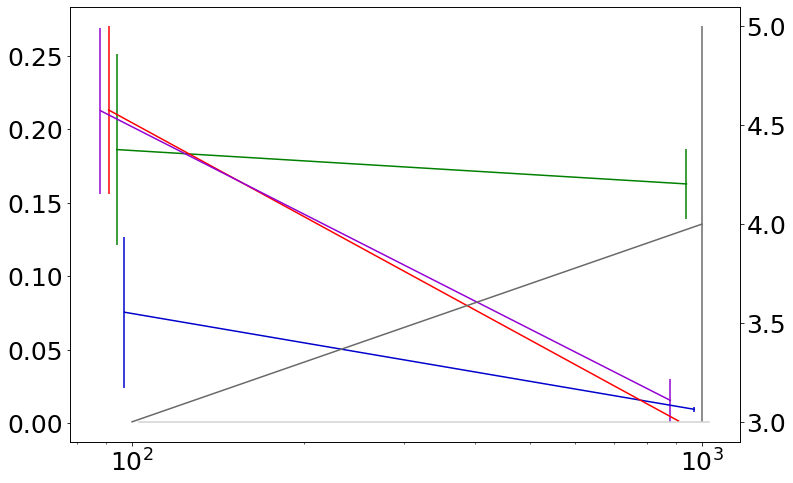

2021-07-22 16:26:49.951459
1d with [['tail']] coarsening with parameters [[array([[-5. ],
       [-0.5],
       [ 0.9]])]]
Coarsening bin bounds: [-1  1] 
Samplesizes: [100, 1000]
Granularities: [3, 5, 10, 20]
Restarts: 5
Experiments: 2
ACA initsize: 20



In [47]:
jitter=0.03

legends=[]

for b in range(len(granularities)):
    legends.append(granularities[b])
    

#figure=plt.figure(figsize=(15,10)) 
figure=plt.figure(figsize=(12,8)) 
ax = figure.add_subplot(111)

#mpl.rcParams['axes.labelsize']=20

# #Individual bin sizes AIM:    
# for bs in range(numbins):
#     y=np.average(score_best_aim[:,:,bs],axis=0)
#     yerr=np.std(score_best_aim[:,:,bs],axis=0)
#     plt.errorbar((1+jitter*bs)*np.array(samplesizes),y,yerr,label=legends[bs])
    
#     y=np.average(score_average_aim[:,:,bs],axis=0)
#     yerr=np.std(score_average_aim[:,:,bs],axis=0)
#     plt.errorbar((1+jitter*bs)*np.array(samplesizes),y,yerr,label="avg"+str(legends[bs]))
    
#ACA:
y=np.average(score_aca[:,:],axis=0)
yerr=np.std(score_aca[:,:],axis=0)
ax.errorbar((1-2*jitter)*np.array(samplesizes),y,yerr,c='green',label='ACA')

#EM:    
y=np.average(score_best_em[:,:],axis=0)
yerr=np.std(score_best_em[:,:],axis=0)
ax.errorbar((1-jitter)*np.array(samplesizes),y,yerr,c='mediumblue',label='EM')


    
#Best binsize AIM:
y=np.average(score_best_aim_optbin[:,:],axis=0)
yerr=np.std(score_best_aim_optbin[:,:],axis=0)
ax.errorbar((1-3*jitter)*np.array(samplesizes),y,yerr,c='red', label='AIM')
#Best binsize EM-AIM:
y=np.average(score_best_em_aim_optbin[:,:],axis=0)
yerr=np.std(score_best_em_aim_optbin[:,:],axis=0)
ax.errorbar((1-4*jitter)*np.array(samplesizes),y,yerr,c='darkviolet',label='EM-AIM')


#Binsize:
axright=ax.twinx()

y=np.average(optbinvals_aim[:,:],axis=0)
yerr=np.std(optbinvals_aim[:,:],axis=0)
axright.errorbar(np.array(samplesizes),y,yerr,c='dimgray',label='# cells (AIM)')

y=np.average(optbinvals_em_aim[:,:],axis=0)
yerr=np.std(optbinvals_em_aim[:,:],axis=0)
axright.errorbar((1+jitter)*np.array(samplesizes),y,yerr,c='lightgray',label='# cells (EM-AIM)')

# Construct the legend
lines, labels = ax.get_legend_handles_labels()
linesr, labelsr = axright.get_legend_handles_labels()
#axright.legend(lines + linesr, labels + labelsr) # use this for local legend inside plot
# axright.legend(lines + linesr, labels + labelsr,loc='upper center', bbox_to_anchor=(0.5, 1.1),
#          ncol=6, fontsize=15, fancybox=True, shadow=True) # use this for separate legend outside


# ax.set_ylabel("squared error", fontsize=20)
# axright.set_ylabel("# cells", fontsize=20)
# ax.set_xlabel("sample size", fontsize=20)
ax.set_xscale('log')

ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
axright.yaxis.set_tick_params(labelsize=25)
#ax.set_ylim((0,0.2))
#plt.legend()    
plt.show()         

print(retrieve['readme'])
